In [1]:
%cd ..


/tempory/NeuralNetworksDIY


In [2]:
import os
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.linear import Linear
from src.loss import *
from src.activation import TanH, Sigmoid, StableSigmoid, Softmax, LogSoftmax, ReLU, LeakyReLU, Softplus
from src.encapsulation import Sequential, Optim
np.random.seed(42)

# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12

# d = {
#     # 'font.size': SMALL_SIZE,
# 'axes.titlesize': SMALL_SIZE,
# # 'axes.labelsize': MEDIUM_SIZE,
# # 'xtick.labelsize': SMALL_SIZE,
# # 'ytick.labelsize': SMALL_SIZE,
# # 'legend.fontsize': SMALL_SIZE,
# 'figure.titlesize': BIGGER_SIZE,}
sns.set_context("talk")


/tempory/NeuralNetworksDIY/src/encapsulation.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
def normalize_batch_image(X):
    mn = np.min(X)
    mx = np.max(X)
    X_norm = (X - mn) * (1.0 / (mx - mn))
    return X_norm


def load_data(rootdir, class_list=None, trim: float = 0.5):

    train = pd.read_csv(os.path.join(rootdir, "fashion-mnist_train.csv"))
    # Filtering requested class
    if class_list:
        train = train[train["label"].isin(class_list)]
    y_train = train["label"].values
    X_train = train.drop(columns="label").values

    test = pd.read_csv(os.path.join(rootdir, "fashion-mnist_test.csv"))
    # Filtering requested class
    if class_list:
        test = test[test["label"].isin(class_list)]
    y_test = test["label"].values
    X_test = test.drop(columns="label").values

    trim_train = int(len(X_train) * trim)
    # trim_test = int(len(X_test) * trim)
    trim_test = int(len(X_test))

    # Normalization + trimming
    X_train = normalize_batch_image(X_train[:trim_train, :])
    X_test = normalize_batch_image(X_test[:trim_test, :])
    y_train = y_train[:trim_train]
    y_test = y_test[:trim_test]

    return (X_train, X_test, y_train, y_test)


rootdir = "./data/fashion-mnist/"
X_train, X_test, y_train, y_test = load_data(rootdir, trim=0.5)

y_train_oh = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
nb_class = y_train_oh.shape[1]
batch_size = 64


# Effet de l'initialisation sur l'apprentissage

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

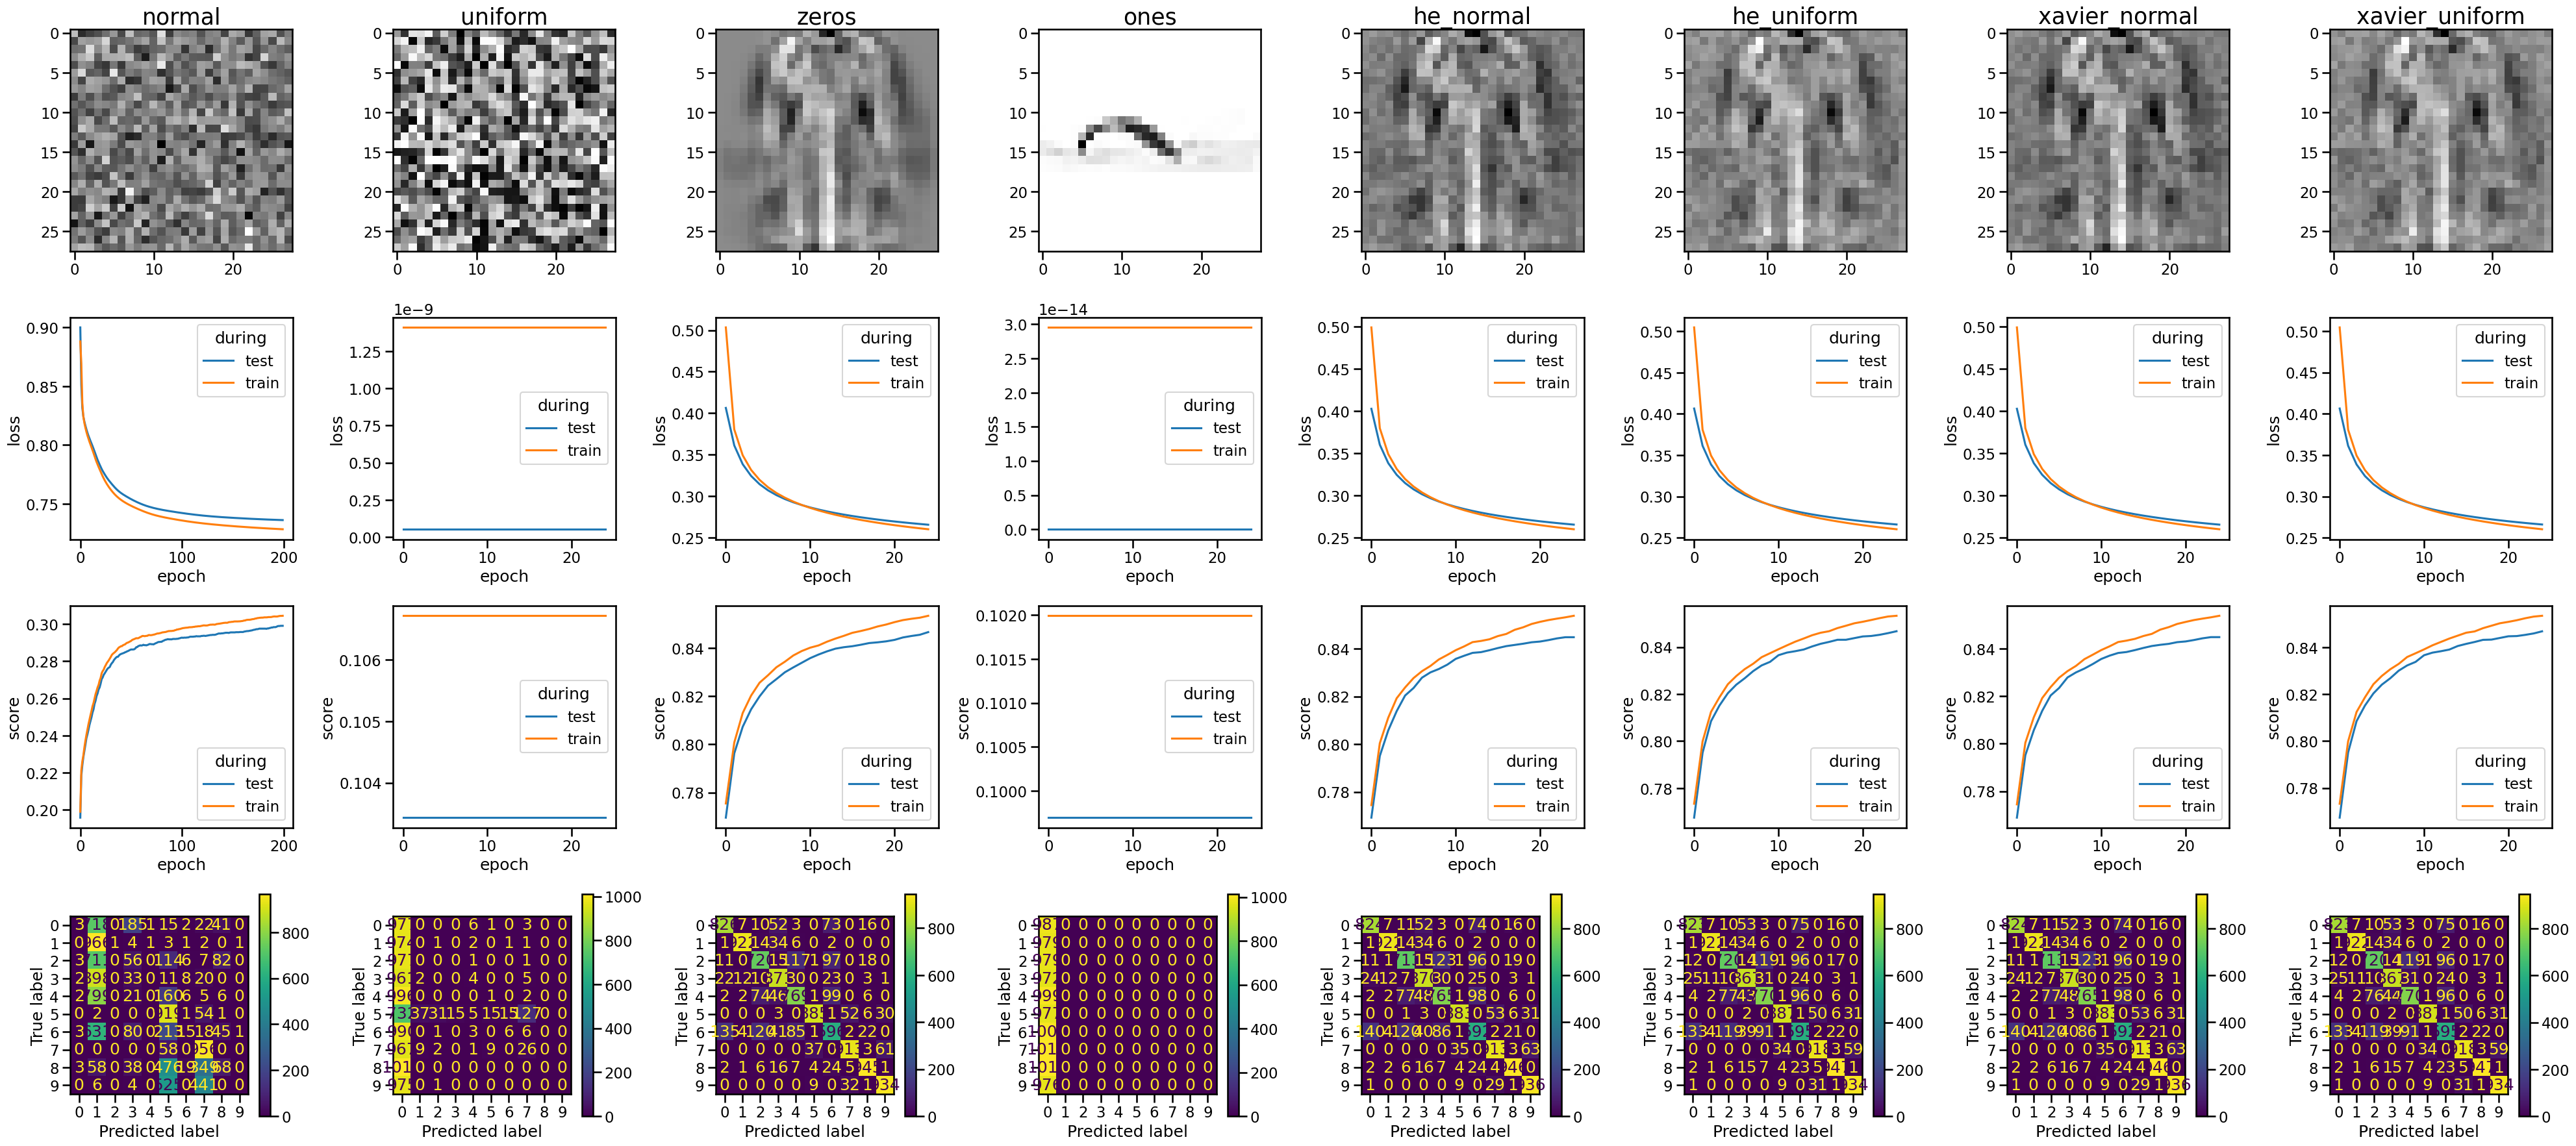

In [4]:
fig, ax = plt.subplots(ncols=8, nrows=4, figsize=(40, 18))
fig.set_tight_layout(True)
for i, init_type in enumerate(['normal', 'uniform', 'zeros', 'ones', 'he_normal', 'he_uniform', 'xavier_normal', 'xavier_uniform']):
    ax_col = ax[:, i]
    ax_col[0].set_title(init_type, size=30)

    net = Sequential(
        Linear(784, 10, init_type=init_type),
        Sigmoid()
    )
    optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=4e-3)
    if init_type == 'normal':
        epoch = 200
    else:
        epoch = 25

    result_df = optimizer.SGD_eval(
        X_train, y_train_oh, batch_size, epoch, test_size=0.33, return_dataframe=True)

    p = net.modules[0]._parameters['weight'][:, 3].reshape(28, 28)
    p = normalize_batch_image(p)
    ax_col[0].imshow(p, cmap='gist_gray')

    loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=[
                           'loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
    sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax_col[1])

    score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=[
                            'score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
    sns.lineplot(score_long_df, x='epoch', y='score',
                 hue='during', ax=ax_col[2])

    ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(
        1), optimizer.network.forward(optimizer.X_test).argmax(1), ax=ax_col[3])

fig.savefig('reports/src/init_type.pdf', dpi=100, bbox_inches="tight")


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

/tmp/ipykernel_9154/3223057822.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  X_norm = (X - mn) * (1.0 / (mx - mn))
/tmp/ipykernel_9154/3223057822.py:4: RuntimeWarning: invalid value encountered in multiply
  X_norm = (X - mn) * (1.0 / (mx - mn))


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

/tmp/ipykernel_9154/3223057822.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  X_norm = (X - mn) * (1.0 / (mx - mn))
/tmp/ipykernel_9154/3223057822.py:4: RuntimeWarning: invalid value encountered in multiply
  X_norm = (X - mn) * (1.0 / (mx - mn))


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

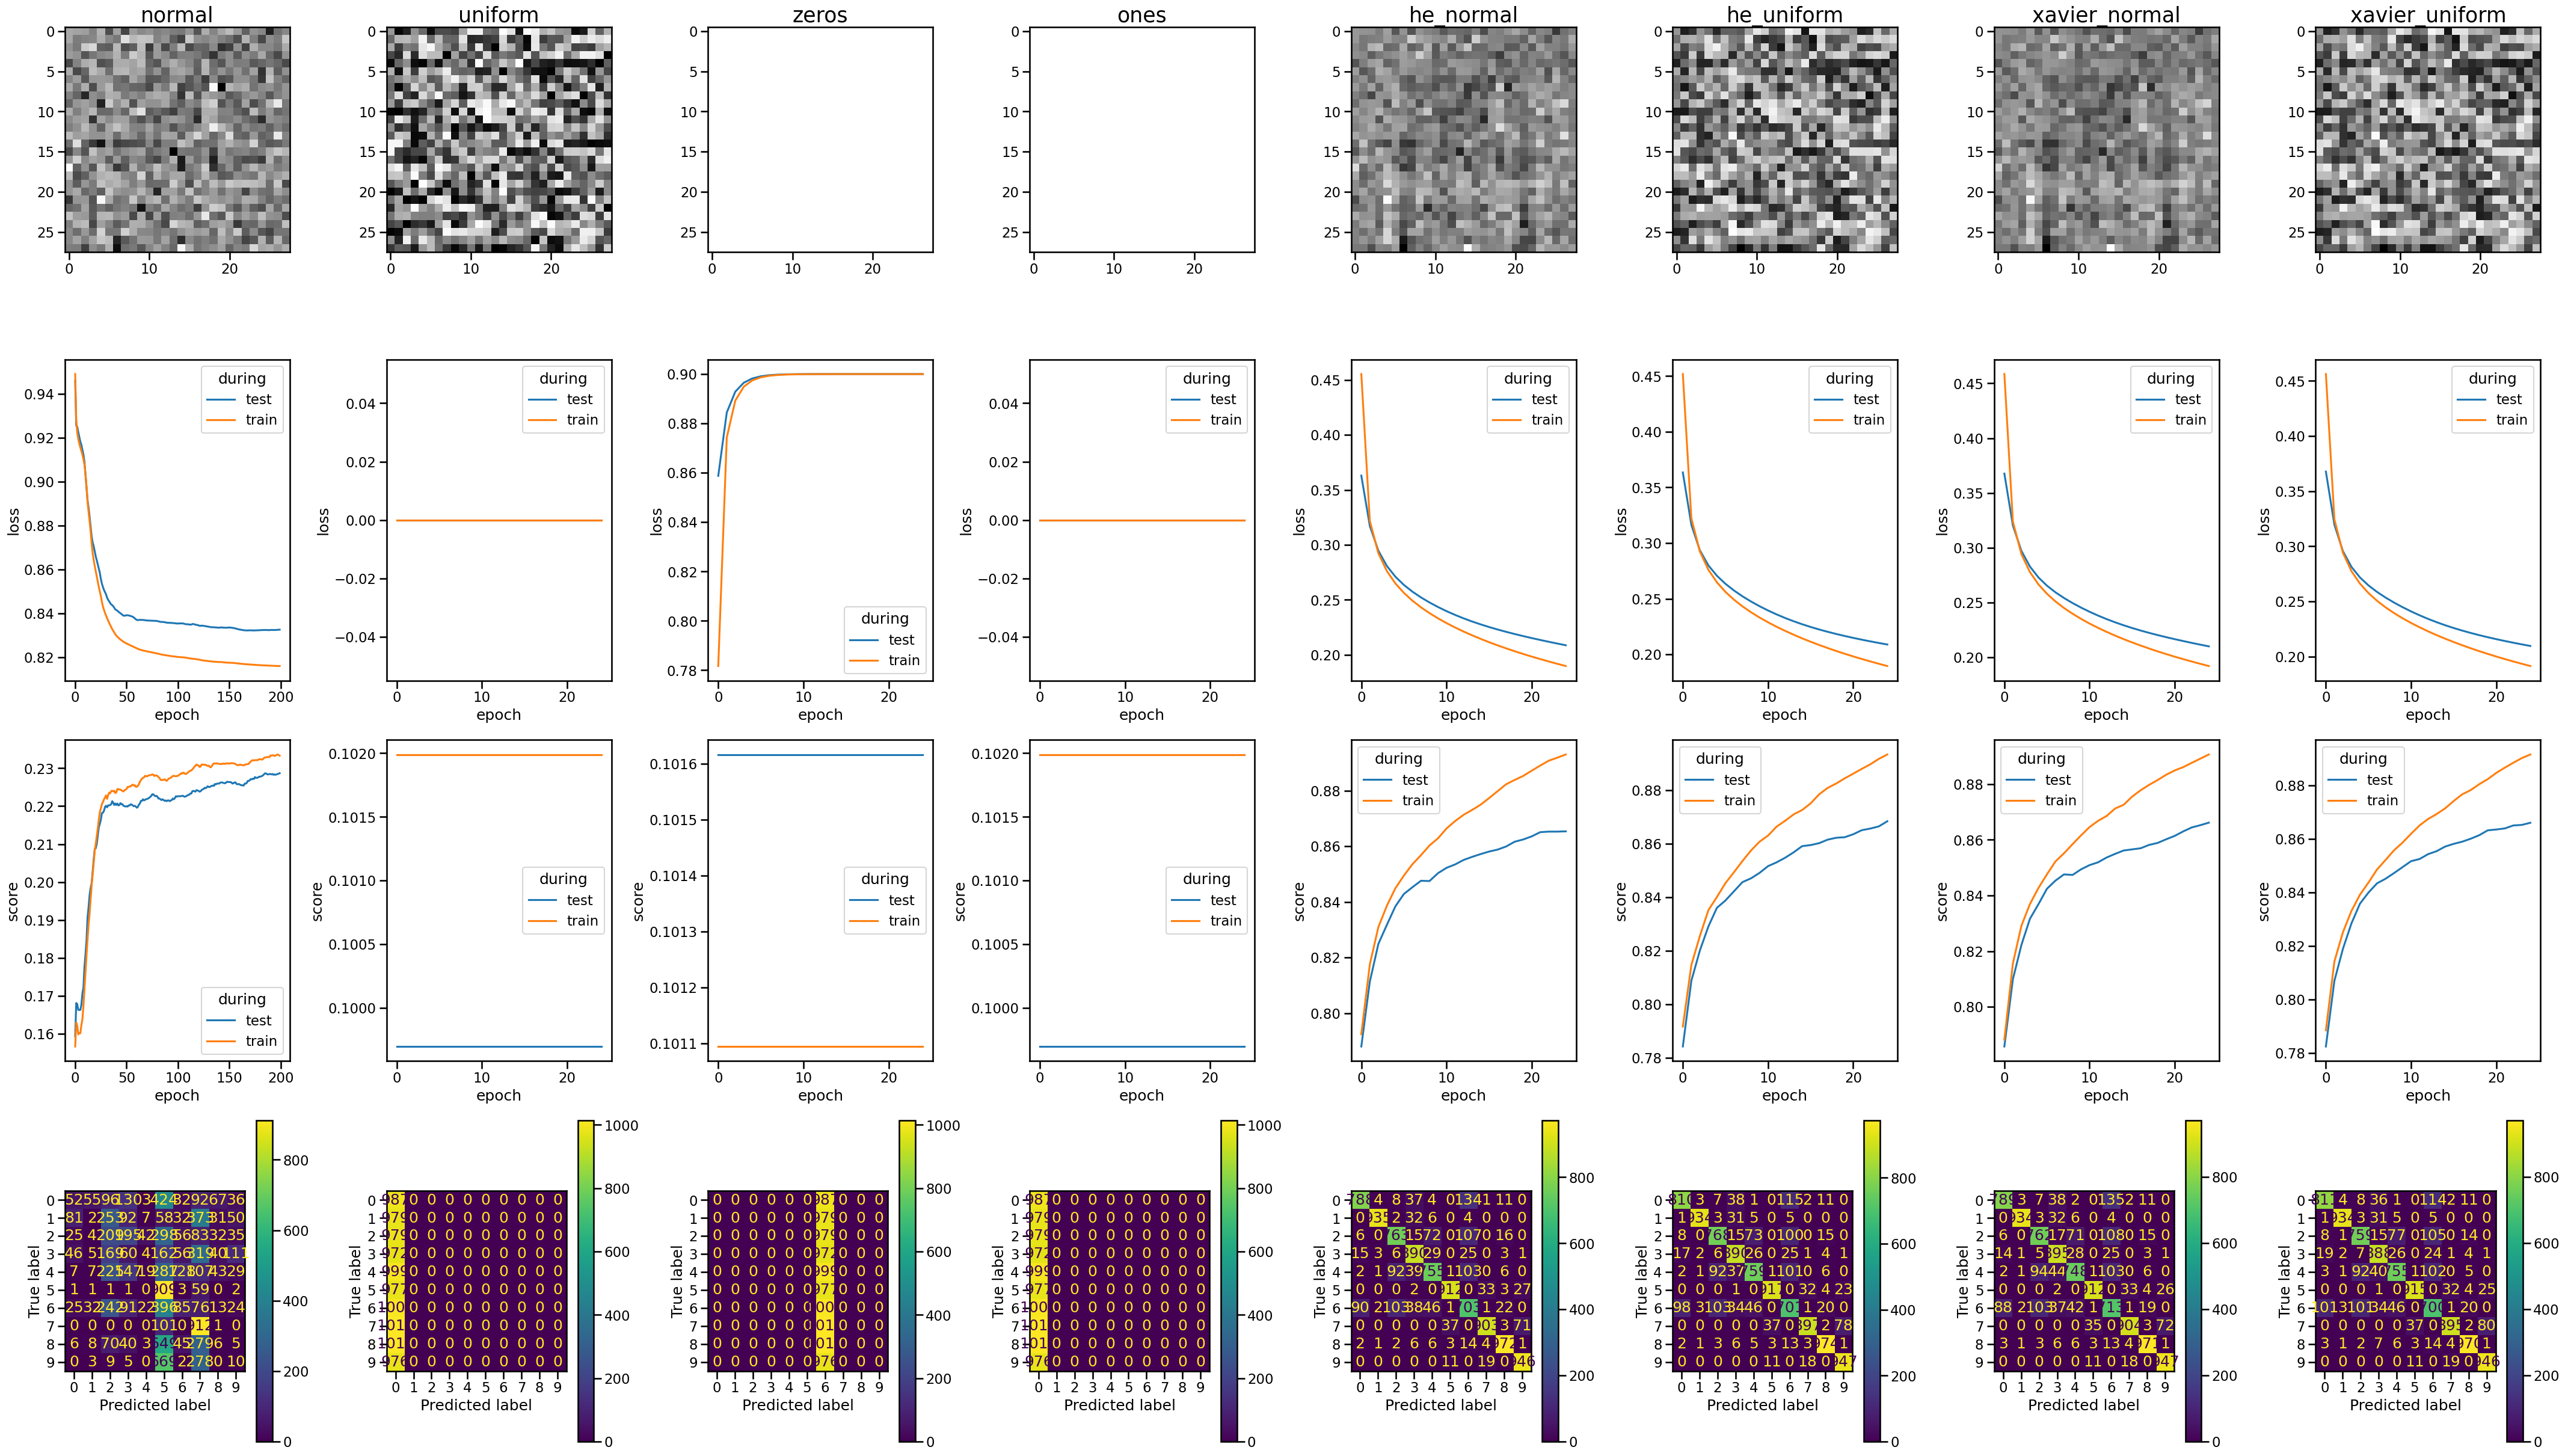

In [5]:
fig, ax = plt.subplots(ncols=8, nrows=4, figsize=(43, 25))
fig.set_tight_layout(True)
for i, init_type in enumerate(['normal', 'uniform', 'zeros', 'ones', 'he_normal', 'he_uniform', 'xavier_normal', 'xavier_uniform']):
    ax_col = ax[:, i]
    ax_col[0].set_title(init_type, size=30)

    net = Sequential(
        Linear(784, 784//2, init_type=init_type),
        TanH(),
        Linear(784//2, 10, init_type=init_type),
        Sigmoid()
    )
    optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=4e-3)
    if init_type == 'normal':
        epoch = 200
    else:
        epoch = 25
    result_df = optimizer.SGD_eval(
        X_train, y_train_oh, batch_size, epoch, test_size=0.33, return_dataframe=True)

    p = net.modules[0]._parameters['weight'][:, 3].reshape(28, 28)
    p = normalize_batch_image(p)
    ax_col[0].imshow(p, cmap='gist_gray')

    loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=[
                           'loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
    sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax_col[1])

    score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=[
                            'score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
    sns.lineplot(score_long_df, x='epoch', y='score',
                 hue='during', ax=ax_col[2])

    ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(
        1), optimizer.network.forward(optimizer.X_test).argmax(1), ax=ax_col[3])
fig.savefig('reports/src/init_type_complex_net.pdf',
            dpi=100, bbox_inches="tight")


# Effet de la learning rate

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

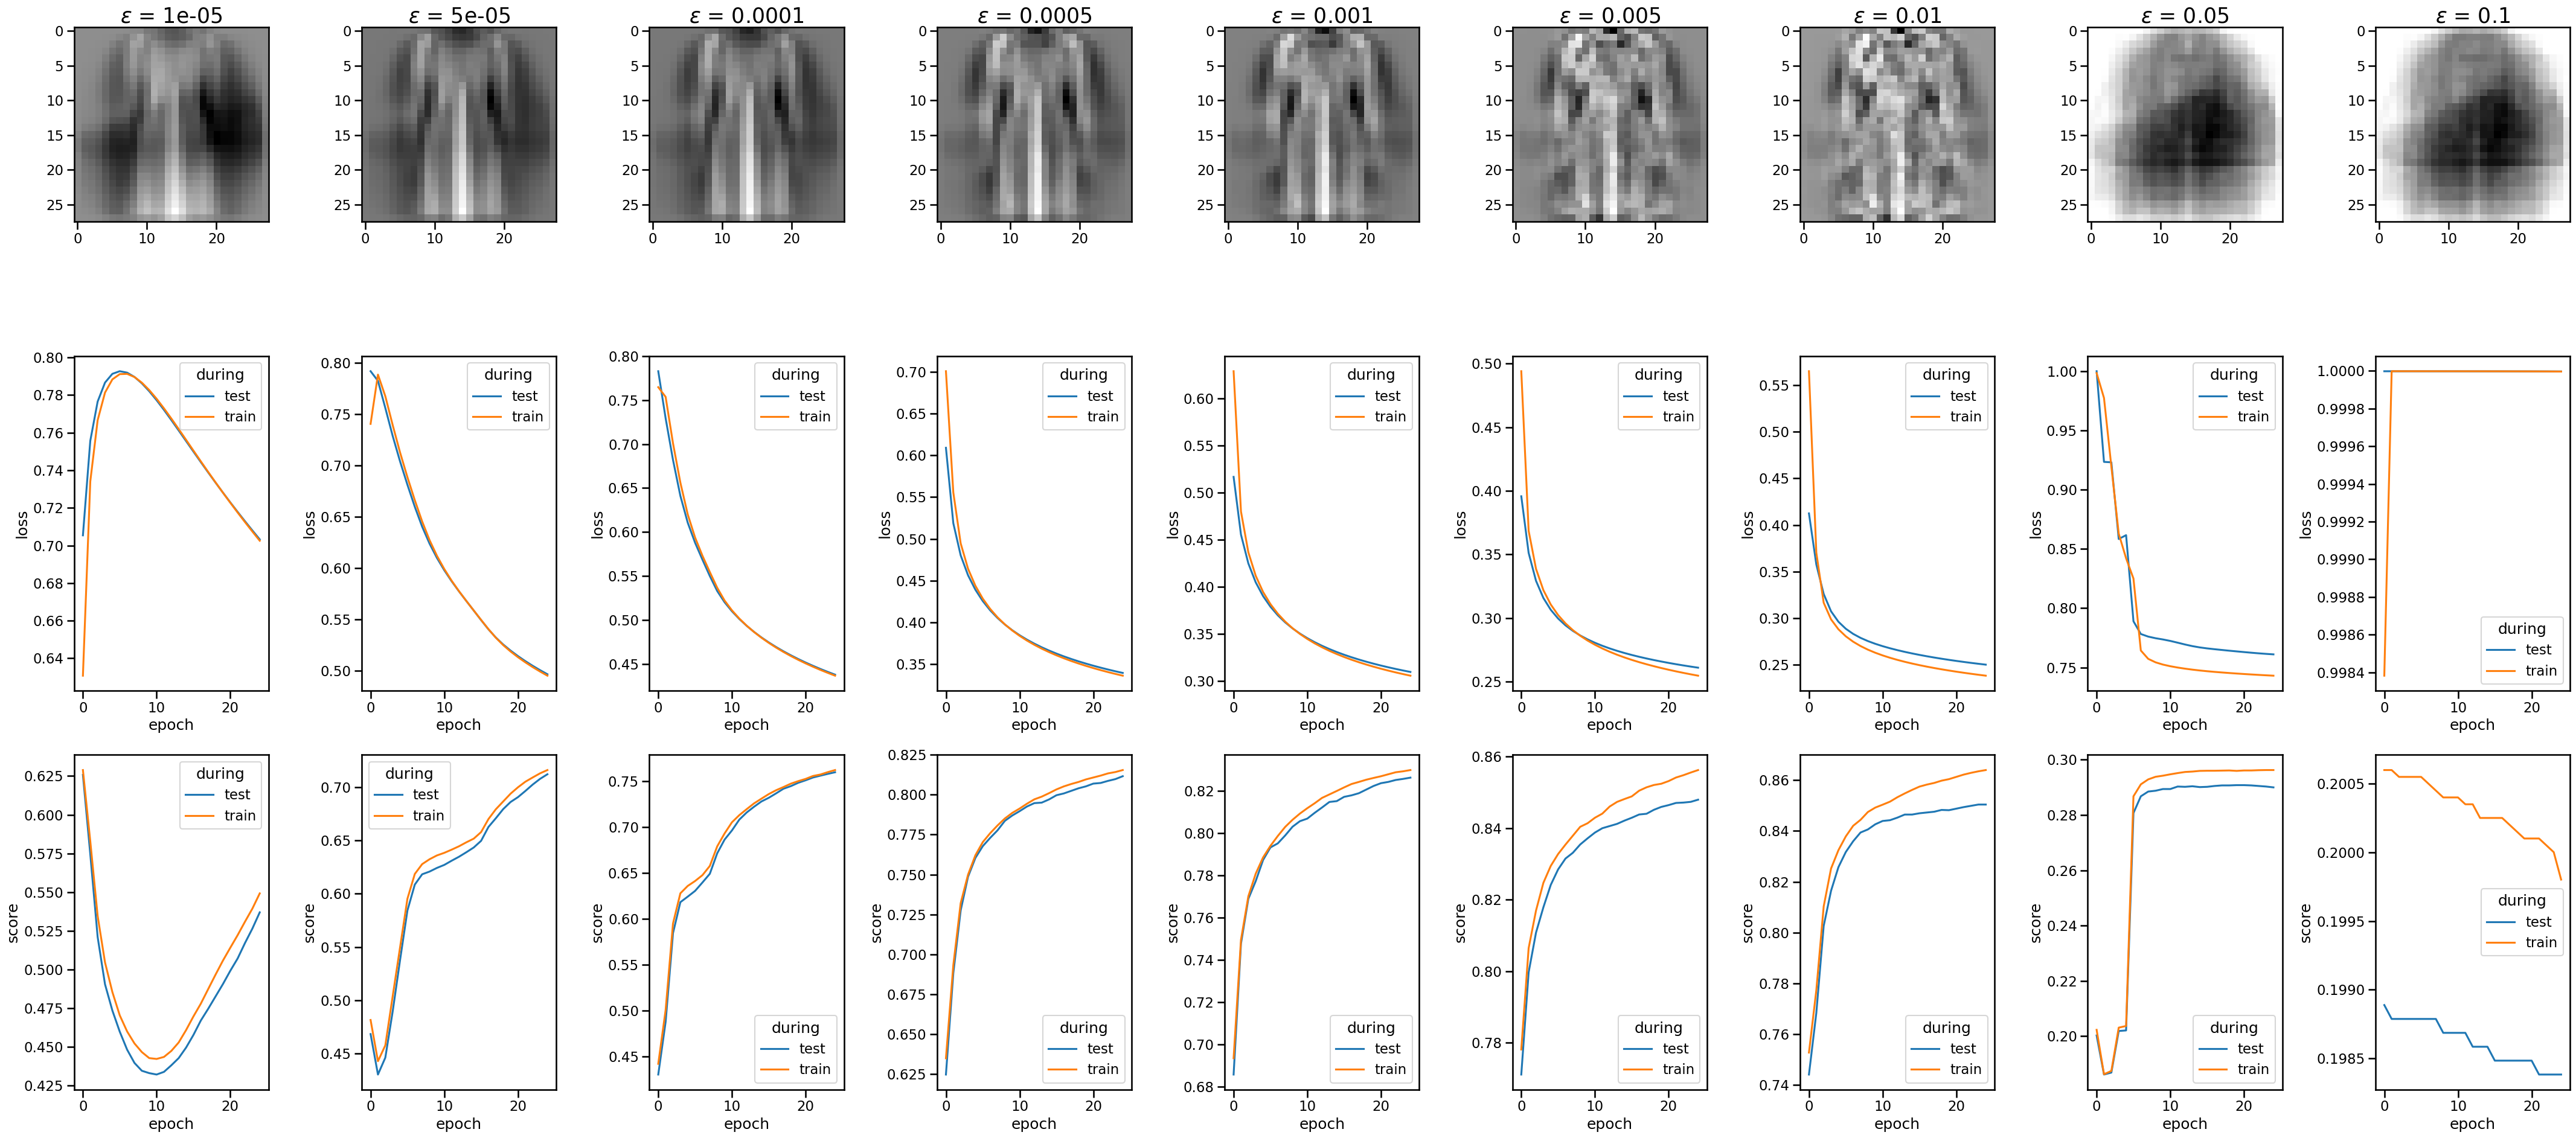

In [6]:
fig, ax = plt.subplots(ncols=9, nrows=3, figsize=(43, 20))
fig.set_tight_layout(True)
net = Sequential(
    Linear(784, 10, init_type='zeros'),
    Sigmoid()
)

for i, lr in enumerate([1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]):
    ax_col = ax[:, i]
    ax_col[0].set_title(f'$\epsilon$ = {lr}', size=30)

    optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=lr)
    epoch = 25
    result_df = optimizer.SGD_eval(
        X_train, y_train_oh, batch_size, epoch, test_size=0.33, return_dataframe=True)

    p = net.modules[0]._parameters['weight'][:, 3].reshape(28, 28)
    p = normalize_batch_image(p)
    ax_col[0].imshow(p, cmap='gist_gray')

    loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=[
                           'loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
    sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax_col[1])

    score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=[
                            'score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
    sns.lineplot(score_long_df, x='epoch', y='score',
                 hue='during', ax=ax_col[2])

fig.savefig('reports/src/lr_effet.pdf', dpi=100, bbox_inches="tight")


enchainer sur l'idée d'ADAM et de learning rate dynamique 

# Effet activation function

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

/tempory/NeuralNetworksDIY/src/activation.py:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))
/tempory/NeuralNetworksDIY/src/activation.py:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

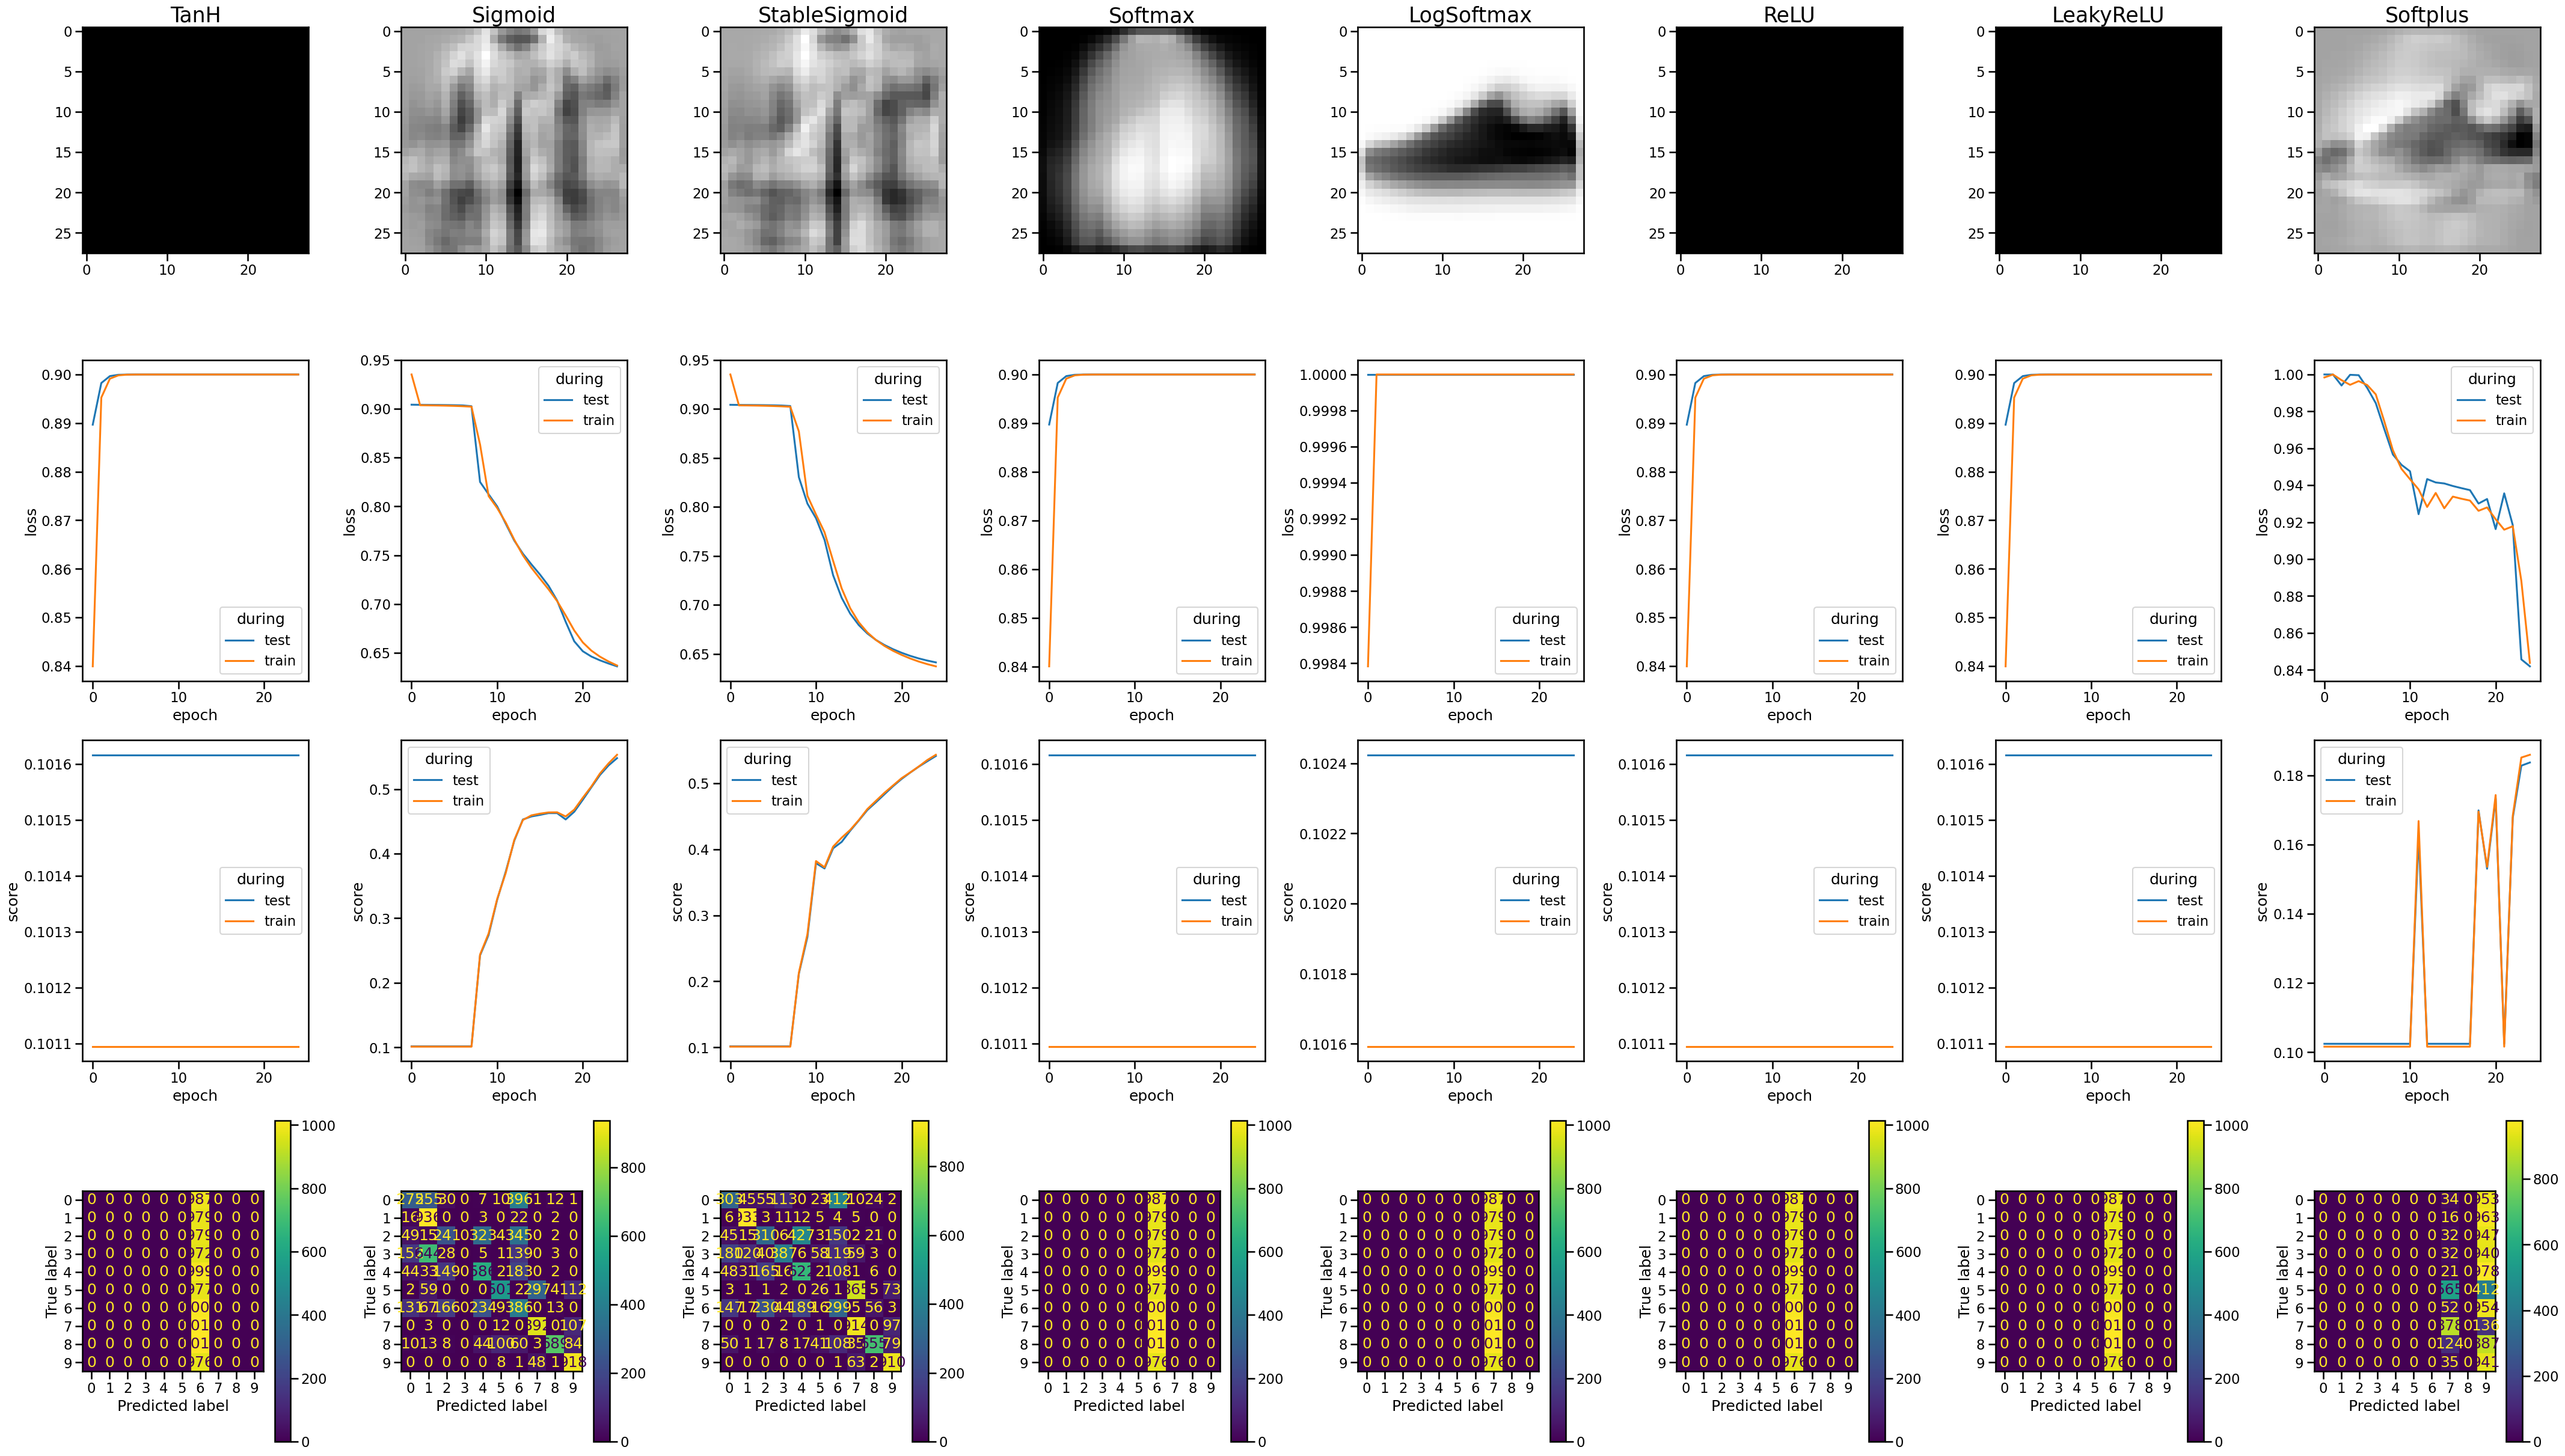

In [7]:
fig, ax = plt.subplots(ncols=8, nrows=4, figsize=(43, 25))
fig.set_tight_layout(True)
for i, act_func in enumerate([TanH, Sigmoid, StableSigmoid, Softmax, LogSoftmax, ReLU, LeakyReLU, Softplus]):
    try:
        ax_col = ax[:, i]
        ax_col[0].set_title(act_func.__name__, size=30)

        net = Sequential(
            Linear(784, 784//2, init_type='zeros'),
            act_func(),
            Linear(784//2, 10, init_type='zeros'),
            Sigmoid(),
        )
        optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=0.01)
        epoch = 25
        result_df = optimizer.SGD_eval(
            X_train, y_train_oh, batch_size, epoch, test_size=0.33, return_dataframe=True)

        p = net.modules[0]._parameters['weight'][:, 3].reshape(28, 28)
        ax_col[0].imshow(p, cmap='gist_gray')

        loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=[
                               'loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
        sns.lineplot(loss_long_df, x='epoch', y='loss',
                     hue='during', ax=ax_col[1])

        score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=[
                                'score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
        sns.lineplot(score_long_df, x='epoch', y='score',
                     hue='during', ax=ax_col[2])

        ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(
            1), optimizer.network.forward(optimizer.X_test).argmax(1), ax=ax_col[3])
    except KeyError:
        continue
fig.savefig('reports/src/activation_func.pdf', dpi=100, bbox_inches="tight")
